In [1]:
###########################################################################
# Example code for running a CNN on MNIST
# Adapted from: https://github.com/yunjey/pytorch-tutorial
###########################################################################

import torch, numpy as np, os
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

# Hyper Parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001
# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [2]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Transforms a 1-channel image to 16 channels, using 5x5 kernels
        # Output is equivalent to a 16 channel image, of half the size (due to max pooling)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            # Batchnorm approximately normalizes input to zero-mean & unit-variance
            # Keeps running values for mean and variance
            # Also linearly transforms the output with learnable params
            nn.BatchNorm2d(16),
            # ReLU non-linearity
            nn.ReLU(),
            # Max pooling (shrinks output by 1/2, to 14x14)
            nn.MaxPool2d(2))
        # Equivalent to transforming from 16 to 32 layers
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # Shrink to 7x7
            nn.MaxPool2d(2))
        # Input: equivalent of a 7x7 image with 32 channels
        # Output: 10 units for 10 digit classes
        self.fc = nn.Linear(7*7*32, 10)
    # Define the forward pass
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

In [3]:
# Instantiate net
cnn = CNN()

In [4]:
# Load trained model
modelFilename = 'mnist-cnn.model'
if os.path.exists(modelFilename):
    cnn.load_state_dict(torch.load(modelFilename))
# Or train from scratch
else: 
    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    # Train the Model
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images)
            labels = Variable(labels)
            # Forward + Backward + Optimize
            optimizer.zero_grad() # Clear stored gradients
            outputs = cnn(images) # CNN forward pass
            loss = criterion(outputs, labels) # Calculate error
            loss.backward() # Compute gradients
            optimizer.step() # Update weights
            if (i+1) % 100 == 0:
                print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

In [5]:
# Save the Trained Model
if not os.path.exists(modelFilename):
    torch.save(cnn.state_dict(), modelFilename)

In [6]:
### Test the Model ###
# Change model to 'eval' mode
# This affects the batch normalization layer, so that it uses the mean/variance obtained in training
cnn.eval()  
# Compute accuracy
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy (10000 test images): %d %%' % (100 * correct / total))

Test Accuracy (10000 test images): 98 %


Input image
torch.Size([1, 1, 28, 28])


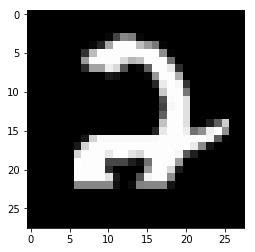

Image after layer 1
torch.Size([1, 16, 14, 14])


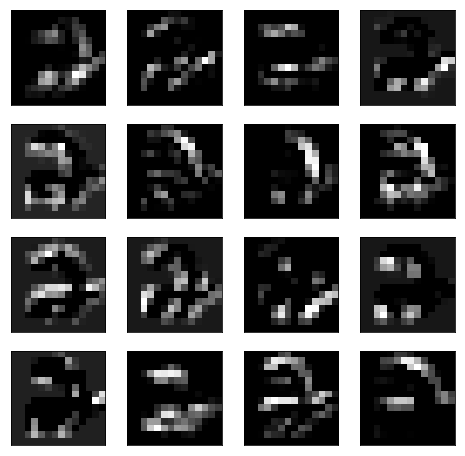

Image after layer 2
torch.Size([1, 32, 7, 7])


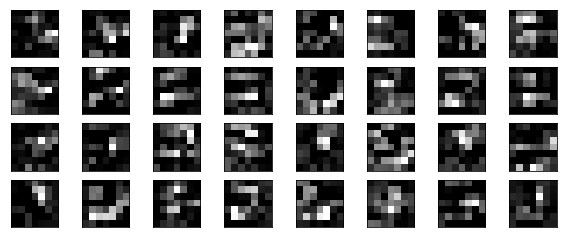

In [8]:
### Let's visualize a training image through the convolution layers ###
import matplotlib.pyplot as plt
# Read in a training image 
trainIter = iter(train_loader) 
images, labels = trainIter.next() 
img = torch.unsqueeze(Variable(images[0]), 0)
fig, ax = plt.subplots()
ax.imshow(img.data.numpy().reshape((28,28)), cmap = plt.cm.gray)
print('Input image')
print(img.shape) # 1 image, 1 channel, WxH = 28x28
plt.show()
img_after_layer1 = cnn.layer1(img)
print('Image after layer 1')
print(img_after_layer1.shape) # 1 image, 16 channels, WxH = 14x14
nChannels = img_after_layer1.data.shape[1]
f, axarr = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    axarr[i//4,i%4].imshow(img_after_layer1.data[0,i,:,:].numpy().reshape((14,14)),
                           cmap = plt.cm.gray, interpolation='nearest', aspect='equal')
for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()
print('Image after layer 2')
img_after_layer2 = cnn.layer2(img_after_layer1)
print(img_after_layer2.shape) # 1 image, 32 channel, WxH = 7x7
f2, axarr2 = plt.subplots(4, 8, figsize=(10,4))
for i in range(32):
    axarr2[i//8,i%8].imshow(img_after_layer2.data[0,i,:,:].numpy().reshape((7,7)),
                            cmap = plt.cm.gray, interpolation='nearest', aspect='equal')
for ax in axarr2.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


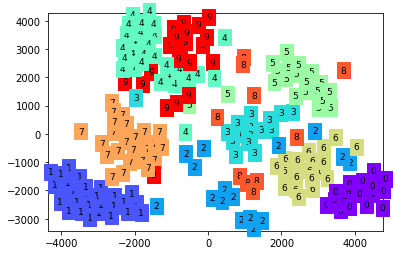

In [14]:
###########################################################################
# Visualize labels clustering based on output from con via tsne
# Note: requires sklearn
# Adapted from: https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/401_CNN.py
###########################################################################
# Grab some test data
plot_only = 200
test_x = Variable( torch.unsqueeze(test_dataset.test_data,1).type(torch.FloatTensor) )[:plot_only]
test_y = test_dataset.test_labels[:plot_only]
# Define a partial forward pass, which returns the representation before the fully connected layer is run
def forwardInclPreFinal(x):
    out = cnn.layer2(cnn.layer1(x))
    outv = out.view(out.size(0), -1)
    return outv
before_last_layer = forwardInclPreFinal(test_x)
# Plot tsne clustering based on conv layer outputs, with labels of correct answer
from matplotlib import cm
from sklearn.manifold import TSNE
def plot_with_labels(lowDWeights, labels):
    plt.cla() # Clear current axis
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()) 
    plt.ylim(Y.min(), Y.max())
    plt.show()
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform( before_last_layer.data.numpy()[:plot_only, :])
labels = test_dataset.test_labels.numpy()[:plot_only]
plot_with_labels(low_dim_embs, labels)